# Informatyka w Medycynie - Symulator tomografu
#### Jakub Buler 155987
#### Adam Detmer 155976

In [6]:
import datetime
import os
import numpy as np

from functools import partial
from multiprocessing import Pool

from math import degrees, radians
from pprint import pprint

from skimage.data import shepp_logan_phantom
from skimage.io import imread
from skimage.color import gray2rgb, rgb2gray

from scipy.fftpack import fft, ifft, fftfreq
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
from ipywidgets import interact, IntSlider, FloatSlider

In [7]:
# DICOM file compatibility
from pydicom.dataset import Dataset, FileDataset
# import pydicom._storage_sopclass_uids
# from pydicom._storage_sopclass_uids import CTImageStorage
from pydicom.uid import ExplicitVRLittleEndian, generate_uid, CTImageStorage
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity

In [8]:
# x1 , y1 - współrzędne początku odcinka
# x2 , y2 - współrzędne końca odcinka
def BresenhamLine(x1, y1, x2, y2):
    x, y = x1, y1
    result = []
    
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    xi = 1 if x1 < x2 else -1
    yi = 1 if y1 < y2 else -1
        
    # pierwszy piksel
    result.append((x, y))
    
    if (dx > dy):
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        
        while (x != x2):
            if (d >= 0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi
                
            result.append((x, y))
    else:
        ai = ( dx - dy ) * 2
        bi = dx * 2
        d = bi - dy
        
        while (y != y2):
            if (d >= 0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
                
            result.append((x, y))
            
    return result

In [22]:
def loadDICOM(_file):
    file = pydicom.dcmread(_file)
    
    pixelData = file.pixel_array
    plt.imshow(pixelData, cmap = 'gray')
    plt.show()
    
    print(file)
    
    print("ID: " + file.PatientID)
    print("Imie i nazwisko: " + str(file.PatientName))
    print(f"Data: {file.StudyDate[0:4]}-{file.StudyDate[4:6]}-{file.StudyDate[6:8]} ")
    print("Komentarz: " + file.ImageComments)

In [20]:
def saveDICOM(file, img, patientData):
    # Metadane pliku
    meta = Dataset()
    meta.MediaStorageSOPClassUID = CTImageStorage
    meta.MediaStorageSOPInstanceUID = generate_uid()
    meta.TransferSyntaxUID = ExplicitVRLittleEndian

    # Utwórz główny dataset
    fd = FileDataset(None, {}, file_meta=meta, preamble=b'\0' * 128)
    fd.is_little_endian = True
    fd.is_implicit_VR = False

    # Uzupełnij wymagane pola
    fd.SOPClassUID = CTImageStorage
    fd.SOPInstanceUID = meta.MediaStorageSOPInstanceUID

    fd.PatientName = patientData["PatientName"]
    fd.PatientID = patientData["PatientID"]
    fd.StudyDate = patientData["StudyDate"]
    fd.ImageComments = patientData["ImageComments"]

    fd.Modality = 'MR'
    fd.SeriesInstanceUID = generate_uid()
    fd.StudyInstanceUID = generate_uid()
    fd.FrameOfReferenceUID = generate_uid()

    fd.BitsStored = 16
    fd.BitsAllocated = 16
    fd.SamplesPerPixel = 1
    fd.HighBit = 15

    fd.ImagesInAcquisition = 1
    fd.InstanceNumber = 1

    # Przetwarzanie obrazu
    img_converted = img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))
    fd.Rows, fd.Columns = img_converted.shape

    fd.ImageType = r'ORIGINAL\PRIMARY\AXIAL'
    fd.PhotometricInterpretation = 'MONOCHROME2'
    fd.PixelRepresentation = 0

    # Walidacja metadanych
    pydicom.dataset.validate_file_meta(fd.file_meta, enforce_standard=True)

    # Zapis danych piksela
    fd.PixelData = img_converted.astype(np.uint16).tobytes()
    fd.save_as(file, write_like_original=False)

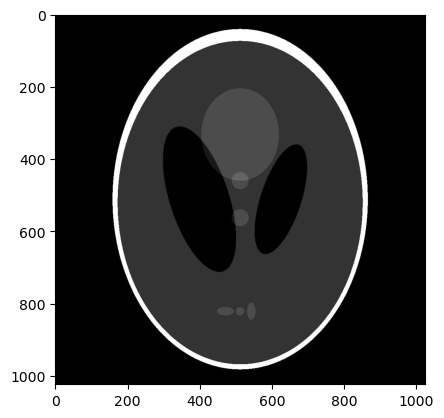

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.73244533538112692097265373890901778691
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.4'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.73244533538112692097265373890901778691
(0008, 0020) Study Date                          DA: '20250403'
(0008, 0060) Modality  

In [23]:
# input_image = shepp_logan_phantom()
input_image = imread("tomograf-obrazy/Shepp_logan.jpg")

if len(input_image.shape) == 3:
    input_image = rgb2gray(input_image)

patient_data = {
    "PatientID" : "2345",
    "PatientName" : "Marek",
    "StudyDate" : "20250403",
    "ImageComments" : "asd"
}

saveDICOM('test.dcm', input_image, patient_data)

loadDICOM("test.dcm")

In [11]:
def calculate_pos(radius, angle, offset=0):
    angle_radians = np.radians(angle + offset)
    x = int(radius * np.cos(angle_radians) + radius)
    y = int(radius * np.sin(angle_radians) + radius)
    return x,y 

In [2]:
# Transformata Radon'a
def radon(image, radius, angle_range, alfa=1, detectors=360, prog=360):
    scans = int(prog / alfa)
    sinogram = np.zeros((scans, detectors))
    
    for i in range(scans):
        angle = alfa * i
        emitter_pos = calculate_pos(radius, angle)
        
        detectors_pos = []
        
        for j in range(detectors):
            offset = 180 - angle_range/2 + j*angle_range/(detectors - 1)
            detectors_pos.append(calculate_pos(radius, angle, offset))
            
        for j, detector_p in enumerate(detectors_pos):
            line = BresenhamLine(emitter_pos[0], emitter_pos[1], detector_p[0], detector_p[1])
            values = [image[y][x] for x, y in line if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]]
            sinogram[i][j] = np.sum(values) / max(1, len(values))
        
    return sinogram



def inverseRadon(sinogram, radius, angle_range, alfa=1, detectors=360, emitter_range=360):
    scans = int(emitter_range / alfa)
    size = 2 * radius
    image = np.zeros((size, size))
    
    for i in range(scans):
        angle = alfa * i
        emitter_pos = calculate_pos(radius, angle)
        
        for j in range(detectors):
            offset = 180 - angle_range/2 + j * (angle_range / (detectors - 1))
            detector_pos = calculate_pos(radius, angle, offset)
            line = BresenhamLine(emitter_pos[0], emitter_pos[1], detector_pos[0], detector_pos[1])
            
            
            for x, y in line:
                if 0 <= x < size and 0 <= y < size:
                    image[y, x] += sinogram[i, j] / len(line)
                    
    image -= np.min(image)
    if np.max(image) != 0:
        image /= np.max(image)

    return image

C:\Users\dell\AppData\Local\Temp\ipykernel_20596\3208302893.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_image_color = imageio.imread(image_path)


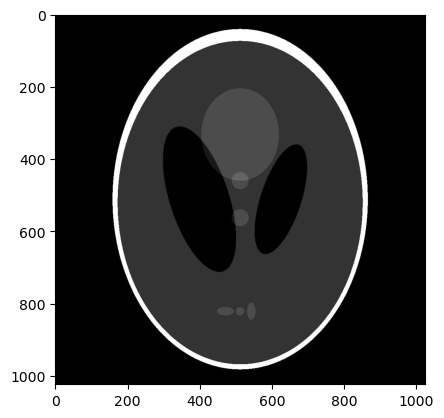

In [10]:
from skimage import color
import imageio

# Read zdjęcie i convert
image_path = 'tomograf-obrazy/Shepp_logan.jpg'

input_image_color = imageio.imread(image_path)
input_image = color.rgb2gray(input_image_color)
plt.imshow(input_image, cmap='gray')
input_image_height, input_image_width = input_image.shape
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from skimage.metrics import mean_squared_error

# Filtrowanie sinogramu za pomocą filtra Ram-Lak
def ramp_filter(sinogram):
    num_detectors = sinogram.shape[1]
    # Stwórz filtr Ram-Lak
    freqs = np.fft.fftfreq(num_detectors).reshape(1, -1)
    filter_ramlak = 2 * np.abs(freqs)

    # Filtracja każdego wiersza sinogramu
    sinogram_fft = np.fft.fft(sinogram, axis=1)
    sinogram_filtered = np.real(np.fft.ifft(sinogram_fft * filter_ramlak, axis=1))
    return sinogram_filtered

# Analiza RMSE dla różnych liczby detektorów
def rmse_vs_detectors(original, radius, angle_range, alpha=1, emitter_range=360):
    detectors_range = range(90, 721, 90)
    rmses_no_filter = []
    rmses_with_filter = []

    for det in detectors_range:
        sinogram = radon(original, radius, angle_range, alpha, det, emitter_range)
        recon_nf = inverseRadon(sinogram, radius, angle_range, alpha, det, emitter_range)
        sinogram_f = ramp_filter(sinogram)
        recon_f = inverseRadon(sinogram_f, radius, angle_range, alpha, det, emitter_range)

        rmses_no_filter.append(mean_squared_error(original, recon_nf))
        rmses_with_filter.append(mean_squared_error(original, recon_f))

    # Wykres
    plt.figure(figsize=(10, 5))
    plt.plot(detectors_range, rmses_no_filter, label='Bez filtrowania')
    plt.plot(detectors_range, rmses_with_filter, label='Z filtrowaniem')
    plt.xlabel("Liczba detektorów")
    plt.ylabel("RMSE")
    plt.title("RMSE w zależności od liczby detektorów")
    plt.legend()
    plt.grid(True)
    plt.show()

# Analiza RMSE dla różnych liczby scnaow
def rmse_vs_scans(original, radius, angle_range, alpha=1, det=360):
    scan_range = range(90, 721, 90)
    rmses_no_filter = []
    rmses_with_filter = []

    for scan in scan_range:
        sinogram = radon(original, radius, angle_range, alpha, det, scan)
        recon_nf = inverseRadon(sinogram, radius, angle_range, alpha, det, scan)
        sinogram_f = ramp_filter(sinogram)
        recon_f = inverseRadon(sinogram_f, radius, angle_range, alpha, det, scan)

        rmses_no_filter.append(mean_squared_error(original, recon_nf))
        rmses_with_filter.append(mean_squared_error(original, recon_f))

    # Wykres
    plt.figure(figsize=(10, 5))
    plt.plot(scan_range, rmses_no_filter, label='Bez filtrowania')
    plt.plot(scan_range, rmses_with_filter, label='Z filtrowaniem')
    plt.xlabel("Liczba detektorów")
    plt.ylabel("RMSE")
    plt.title("RMSE w zależności od liczby detektorów")
    plt.legend()
    plt.grid(True)
    plt.show()
# Analiza RMSE dla konkretnego przypadku (rekonstrukcja z i bez filtra)
def compare_filtered_vs_unfiltered(original, radius, angle_range=270, alpha=1, detectors=360, emitter_range=360):
    sinogram = radon(original, radius, angle_range, alpha, detectors, emitter_range)
    recon_nf = inverseRadon(sinogram, radius, angle_range, alpha, detectors, emitter_range)
    sinogram_f = ramp_filter(sinogram)
    recon_f = inverseRadon(sinogram_f, radius, angle_range, alpha, detectors, emitter_range)

    rmse_nf = mean_squared_error(recon_nf,original)
    rmse_f = mean_squared_error(recon_f,original)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title("Oryginał")
    ax[1].imshow(recon_nf, cmap='gray')
    ax[1].set_title(f"Bez filtra\nRMSE: {rmse_nf:.4f}")
    ax[2].imshow(recon_f, cmap='gray')
    ax[2].set_title(f"Z filtrem\nRMSE: {rmse_f:.4f}")
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()
    
    return rmse_nf, rmse_f


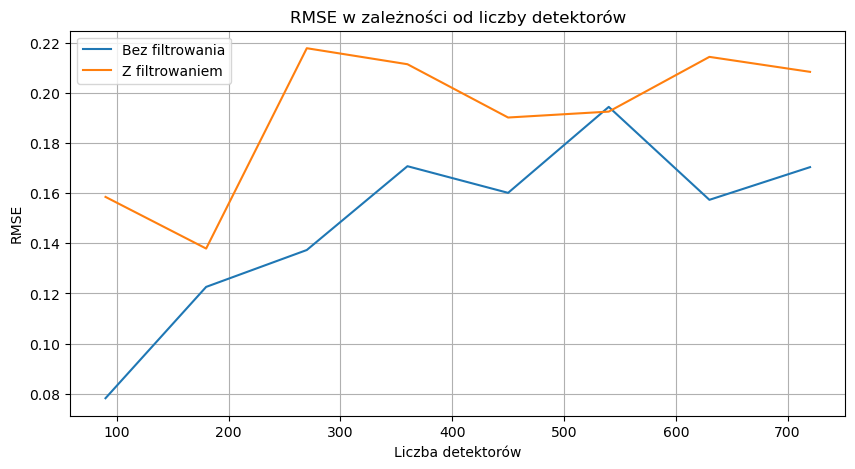

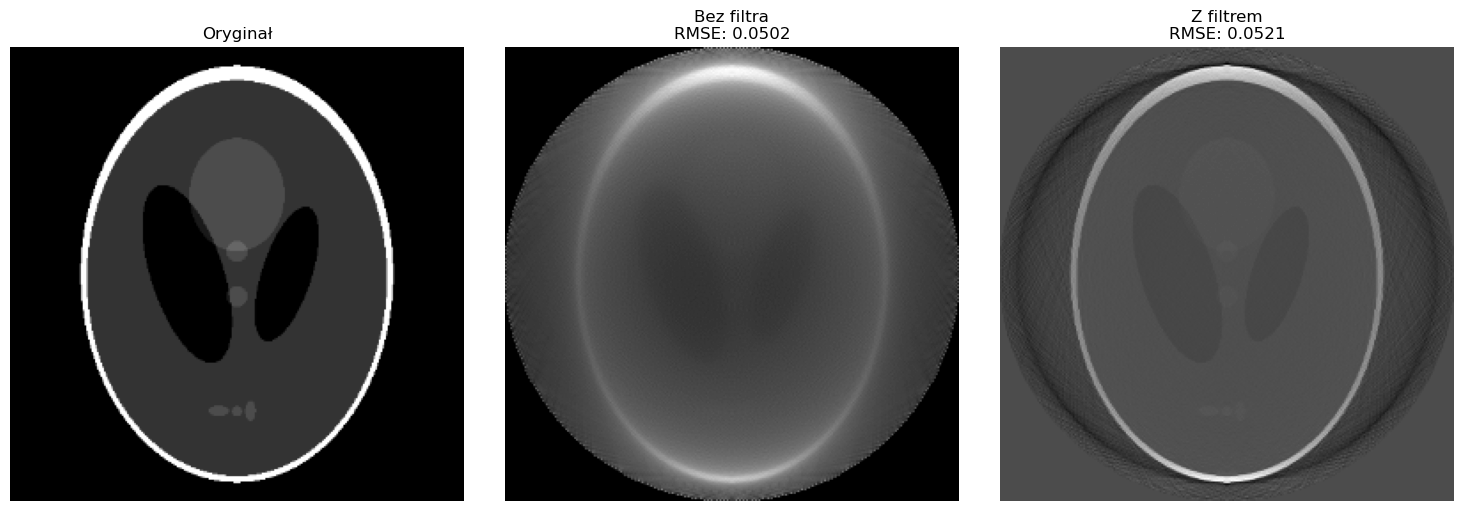

(0.05015461714692426, 0.052104192107666716)

In [12]:
# Wczytanie i przygotowanie obrazu
from skimage.data import shepp_logan_phantom
from skimage.transform import resize

original = resize(shepp_logan_phantom(), (256, 256), anti_aliasing=True)
radius = original.shape[0] // 2

# Analiza jakości dla różnych detektorów
# rmse_vs_detectors(original, radius, angle_range=180)
rmse_vs_scans(original,radius,angle_range=180)
# Porównanie z filtrem i bez
compare_filtered_vs_unfiltered(original, radius)


In [ ]:
rmse_vs_detectors(original, radius, angle_range=180)

C:\Users\HP\AppData\Local\Temp\ipykernel_2600\2872392878.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_image = imageio.imread(image_path)


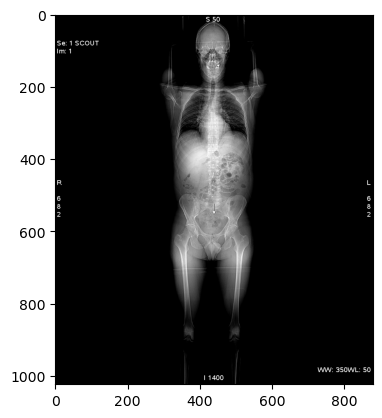

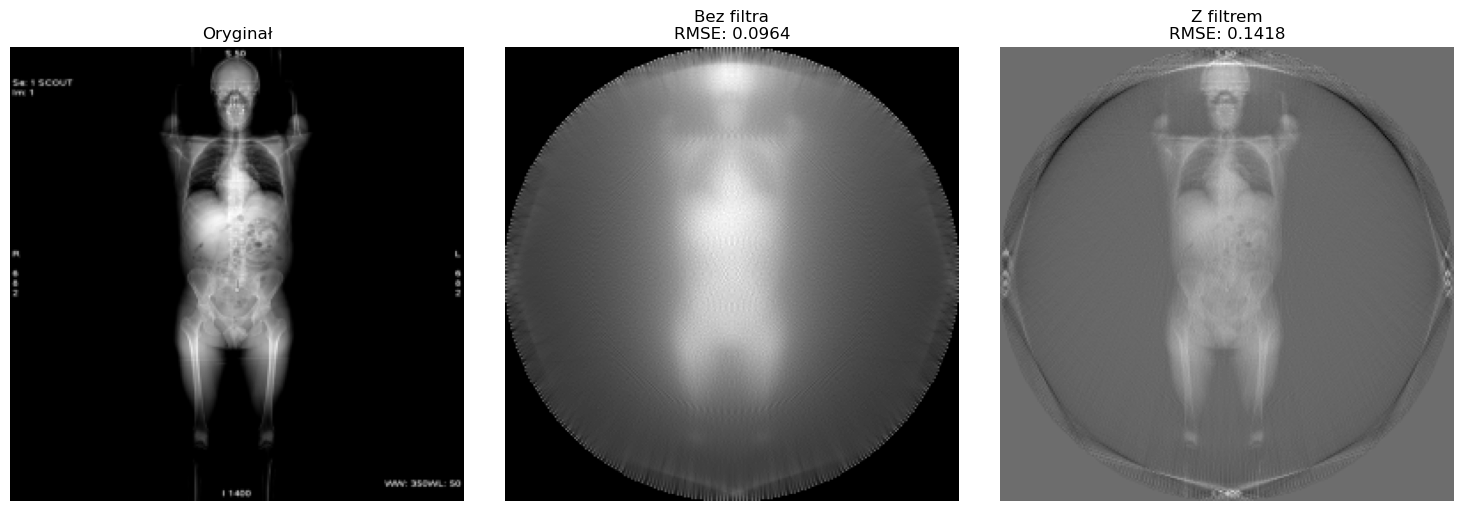

(0.0964214433948933, 0.14182275216039597)

In [44]:
# Wczytanie i przygotowanie obrazu
from skimage.data import shepp_logan_phantom
from skimage.transform import resize

image_path = 'tomograf-obrazy/CT_ScoutView.jpg'

input_image = imageio.imread(image_path)
plt.imshow(input_image, cmap='gray')
original = resize(input_image, (256, 256), anti_aliasing=True)
radius = original.shape[0] // 2

# Analiza jakości dla różnych detektorów
# rmse_vs_detectors(original, radius, angle_range=180)

# Porównanie z filtrem i bez
compare_filtered_vs_unfiltered(original, radius)

In [12]:
from ipywidgets import interact, IntSlider
from skimage.transform import resize

angle_range = 180
original = resize(shepp_logan_phantom(), (256, 256), anti_aliasing=True)
radius = original.shape[0] // 2

@interact(angle_max=IntSlider(min=1, max=360, step=1, value=1, description="Kąt [°]"))
def show_partial_radon(angle_max):
    sinogram = radon(original, radius, angle_range=angle_range, alfa=1, detectors=360, prog=angle_max)
    plt.figure(figsize=(10, 5))
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.title(f"Sinogram do kąta {angle_max}°")
    plt.xlabel("Detektory")
    plt.ylabel("Skan (kąt)")
    plt.colorbar(label="Intensywność")
    plt.show()


interactive(children=(IntSlider(value=1, description='Kąt [°]', max=360, min=1), Output()), _dom_classes=('wid…

In [13]:
@interact(angle_max=IntSlider(min=1, max=360, step=1, value=1, description="Kąt [°]"))
def show_partial_reconstruction(angle_max):
    sinogram = radon(original, radius, angle_range=angle_range, alfa=1, detectors=360, prog=angle_max)
    recon = inverseRadon(sinogram, radius, angle_range=angle_range, alfa=1, detectors=360, emitter_range=angle_max)
    plt.figure(figsize=(6, 6))
    plt.imshow(recon, cmap='gray')
    plt.title(f"Rekonstrukcja do kąta {angle_max}°")
    plt.axis('off')
    plt.show()


interactive(children=(IntSlider(value=1, description='Kąt [°]', max=360, min=1), Output()), _dom_classes=('wid…

In [14]:
from scipy.signal import convolve
import numpy as np

def ram_lak_kernel(size):
    """
    Tworzy jądro Ram-Laka do filtracji sinogramu w dziedzinie czasu.
    """
    n = np.arange(-size//2, size//2 + 1)
    kernel = np.zeros_like(n, dtype=float)
    for i in range(len(n)):
        if n[i] == 0:
            kernel[i] = 1 / 4.0
        elif n[i] % 2 == 0:
            kernel[i] = 0.0
        else:
            kernel[i] = -1 / (np.pi**2 * n[i]**2)
    return kernel

def ramp_filter(sinogram):
    """
    Filtrowanie sinogramu przez splot z filtrem Ram-Laka (dziedzina czasu).
    """
    kernel = ram_lak_kernel(sinogram.shape[1] // 2)
    filtered = np.array([convolve(row, kernel, mode='same') for row in sinogram])
    return filtered


def rmse_vs_scans(original, radius, angle_range, alpha=1, det=360):
    scan_range = range(90, 721, 90)
    rmses_no_filter = []
    rmses_with_filter = []

    for scan in scan_range:
        sinogram = radon(original, radius, angle_range, alpha, det, scan)
        recon_nf = inverseRadon(sinogram, radius, angle_range, alpha, det, scan)
        sinogram_f = ramp_filter(sinogram)
        recon_f = inverseRadon(sinogram_f, radius, angle_range, alpha, det, scan)

        rmses_no_filter.append(mean_squared_error(original, recon_nf))
        rmses_with_filter.append(mean_squared_error(original, recon_f))

    # Wykres
    plt.figure(figsize=(10, 5))
    plt.plot(scan_range, rmses_no_filter, label='Bez filtrowania')
    plt.plot(scan_range, rmses_with_filter, label='Z filtrowaniem')
    plt.xlabel("Liczba detektorów")
    plt.ylabel("RMSE")
    plt.title("RMSE w zależności od liczby detektorów")
    plt.legend()
    plt.grid(True)
    plt.show()
# Analiza RMSE dla konkretnego przypadku (rekonstrukcja z i bez filtra)
def compare_filtered_vs_unfiltered(original, radius, angle_range=270, alpha=1, detectors=360, emitter_range=360):
    sinogram = radon(original, radius, angle_range, alpha, detectors, emitter_range)
    recon_nf = inverseRadon(sinogram, radius, angle_range, alpha, detectors, emitter_range)
    sinogram_f = ramp_filter(sinogram)
    recon_f = inverseRadon(sinogram_f, radius, angle_range, alpha, detectors, emitter_range)

    rmse_nf = mean_squared_error(recon_nf,original)
    rmse_f = mean_squared_error(recon_f,original)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title("Oryginał")
    ax[1].imshow(recon_nf, cmap='gray')
    ax[1].set_title(f"Bez filtra\nRMSE: {rmse_nf:.4f}")
    ax[2].imshow(recon_f, cmap='gray')
    ax[2].set_title(f"Z filtrem\nRMSE: {rmse_f:.4f}")
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()
    
    return rmse_nf, rmse_f

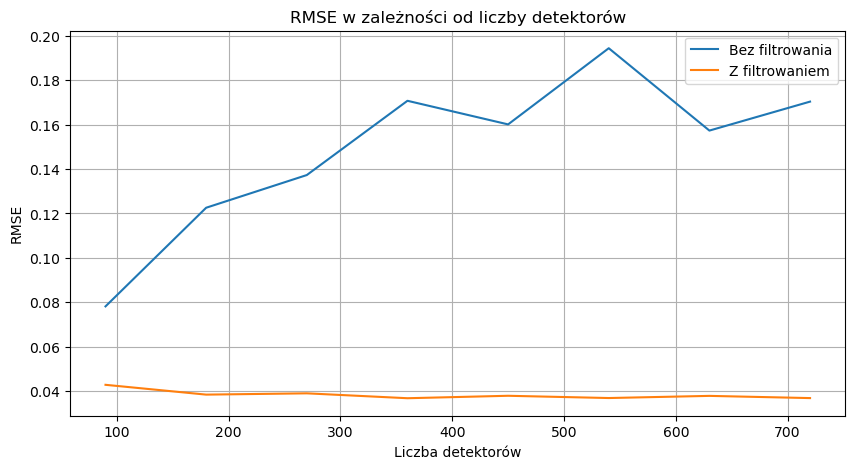

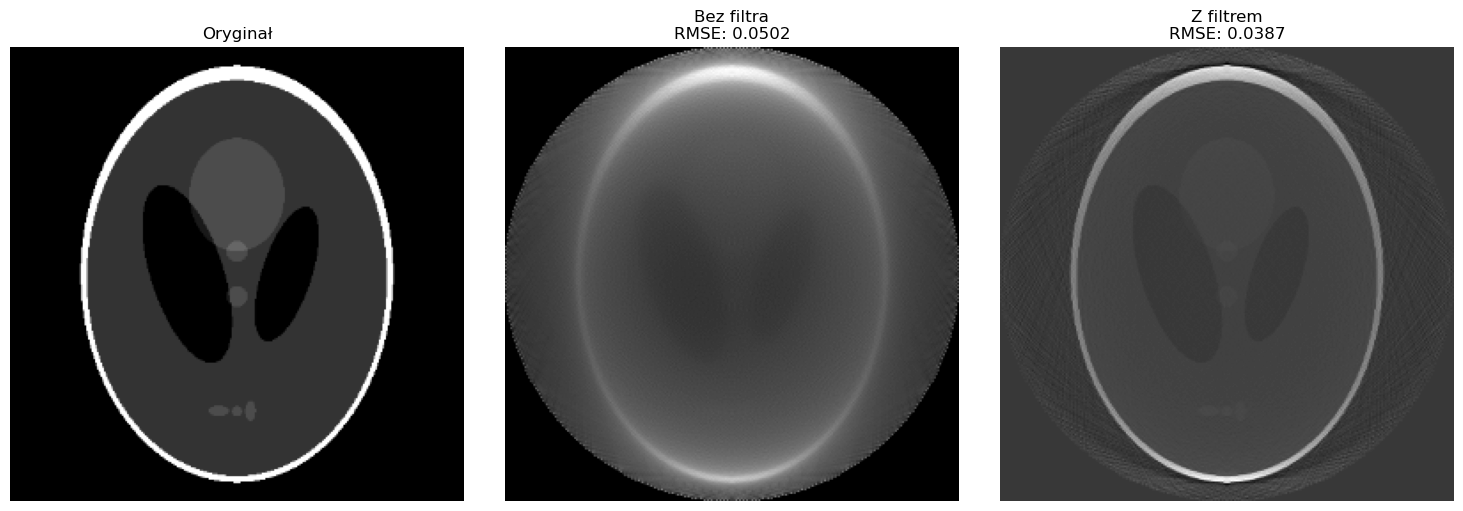

(0.05015461714692426, 0.03865395189892272)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from skimage.metrics import mean_squared_error
from skimage.data import shepp_logan_phantom
from skimage.transform import resize

original = resize(shepp_logan_phantom(), (256, 256), anti_aliasing=True)
radius = original.shape[0] // 2

# Analiza jakości dla różnych detektorów
# rmse_vs_detectors(original, radius, angle_range=180)
rmse_vs_scans(original,radius,angle_range=180)
# Porównanie z filtrem i bez
compare_filtered_vs_unfiltered(original, radius)


C:\Users\dell\AppData\Local\Temp\ipykernel_16912\2207448001.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_image = imageio.imread(image_path)


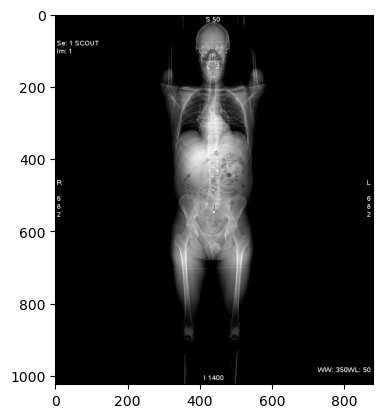

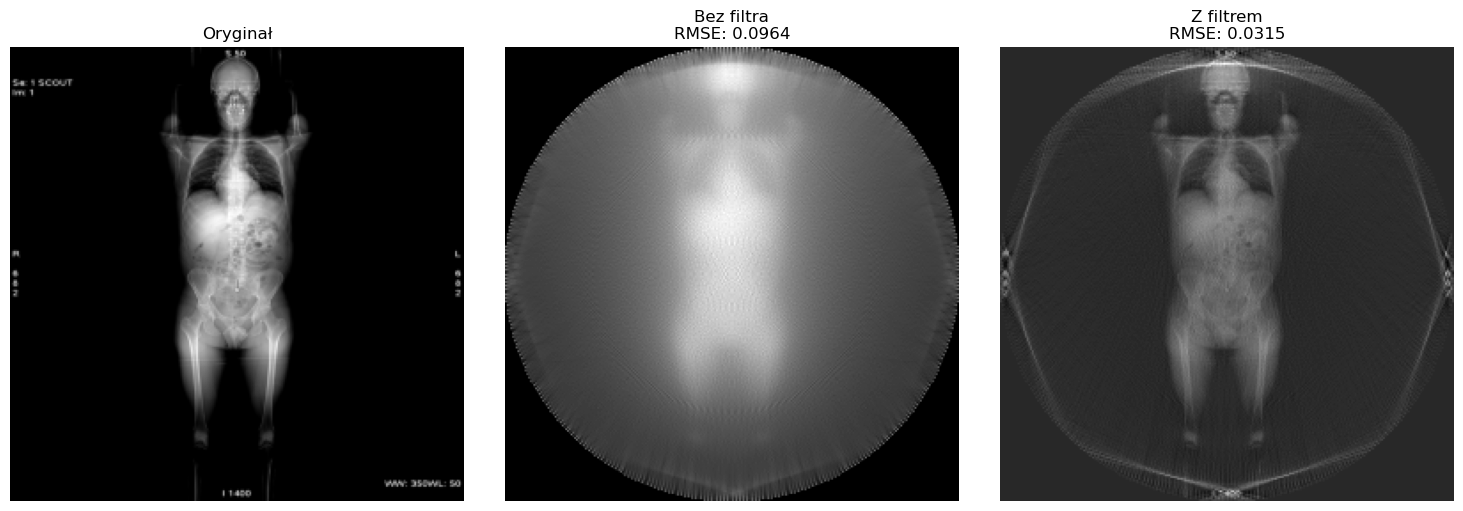

(0.0964214433948933, 0.03150276977023199)

In [19]:
# Wczytanie i przygotowanie obrazu
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from skimage import color
import imageio

image_path = 'tomograf-obrazy/CT_ScoutView.jpg'

input_image = imageio.imread(image_path)
plt.imshow(input_image, cmap='gray')
original = resize(input_image, (256, 256), anti_aliasing=True)
radius = original.shape[0] // 2

# Analiza jakości dla różnych detektorów
# rmse_vs_detectors(original, radius, angle_range=180)

# Porównanie z filtrem i bez
compare_filtered_vs_unfiltered(original, radius)